In [1]:
# Importing the necessary libraries for this analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
!pip install pmdarima
import pmdarima as pm
warnings.filterwarnings("ignore")

In [2]:
# reading the World Covid 19 Cases Data
df=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [3]:
# removing every date and case after the 10th of December 2020
df.drop(df.iloc[:,328:].columns, axis=1, inplace = True)

##### Where to get the dataset for Part 4 from 
https://storage.covid19datahub.io/data-2.csv

In [4]:
# reading the second dataset for part 4 question
df1 = pd.read_csv('data-2.csv',index_col='date', parse_dates=True)

In [5]:
# selecting the province "Ontario" from the 1st dataset to analyse the cases in Ontario
ontario_df = df[(df['Country/Region']=='Canada') & (df['Province/State']=='Ontario')]

In [6]:
# selecting ontario from dataset 2
df_ontario = df1[(df1['administrative_area_level_1']=='Canada') & (df1['administrative_area_level_2']=='Ontario')]

In [7]:
# removing every date and cases after the 10th of december 2020
df_ontario.drop(df_ontario.loc['2020-12-11':].index, inplace=True)

### Data Preparaion and Preprocessing

The first step i took here was to transpose the first dataset so that the date would become the index, and the number of cases per day would be transposed as a column (49) in the dataset. Next, i selected cases starting from March 2020 to December 10th 2020 for analysis. After which,  i transformed the datatype of the the index from string to a datatime index for easier analysis and modelling

In [8]:
onts = ontario_df.transpose().iloc[4:]
y=onts[39:]
y=y[49].apply(float)
y = pd.DataFrame(y)
y.index=pd.to_datetime(y.index)

For the second dataset, the first step i took in this preprocessing stage was to select only cases starting from March 2020 for analysis. After which i selected the columns of interest from the dataset. Columns that may be useful for Exploratory Data Analysis and for answering the question in part 4 and 5

In [9]:
# Using only cases that start from march 2020 for my analysis
df_onts2 = df_ontario.loc['2020-03-01':]
data2_onts = df_onts2[['confirmed', 'gatherings_restrictions','stay_home_restrictions','contact_tracing','school_closing','stringency_index',
                    'internal_movement_restrictions','international_movement_restrictions','testing_policy','workplace_closing']]

In [10]:
# checking for nulls
df_onts2.isna().sum().sum()
ontario_df.isna().sum().sum()

0

In [11]:
# creating a column for the number of daily cases from the cumulative number of cases. There would be 2 days where the values are zero and the
# cumulative number for the first day of march is assumed to be the number for that day
list_daily =[]
for i in range(len(data2_onts.index)):
    if i==0:
        daily_cases = data2_onts.confirmed[i]
        list_daily.append(daily_cases)
    else:
        daily_cases = data2_onts.confirmed[i]-data2_onts.confirmed[i-1]
        list_daily.append(daily_cases)
data2_onts['daily_confirmed'] = list_daily

In [12]:
# creating a column for the number of daily cases from the cumulative number of cases.
# 2 days(one in the beginning of march and the other mid october have zero values)
list_daily_y =[]
for i in range(len(y.index)):
    if i==0:
        daily_cases = y[49][i]
        list_daily_y.append(daily_cases)
    else:
        daily_cases = y[49][i]-y[49][i-1]
        list_daily_y.append(daily_cases)
y['daily_confirmed'] = list_daily_y

### EXPLORATORY DATA ANALYSIS

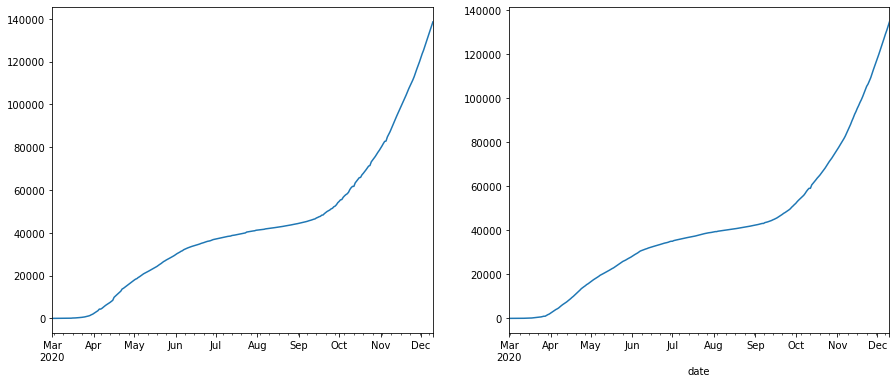

In [13]:
# checking to see that there is a correlation in the cumulative number of cases for the two datasets
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
y[49].plot(ax=ax1)
data2_onts['confirmed'].plot(ax=ax2)

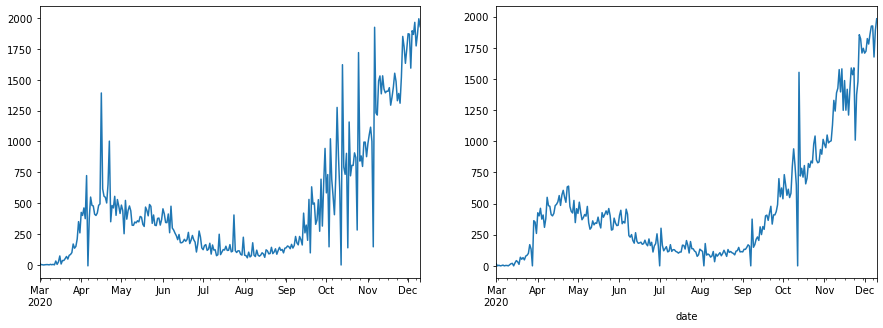

In [14]:
# also comparing a plot of the daily cases for the two datasets
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
y['daily_confirmed'].plot(ax=ax1)
data2_onts.daily_confirmed.plot(ax=ax2)

(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]),
 <a list of 11 Text major ticklabel objects>)

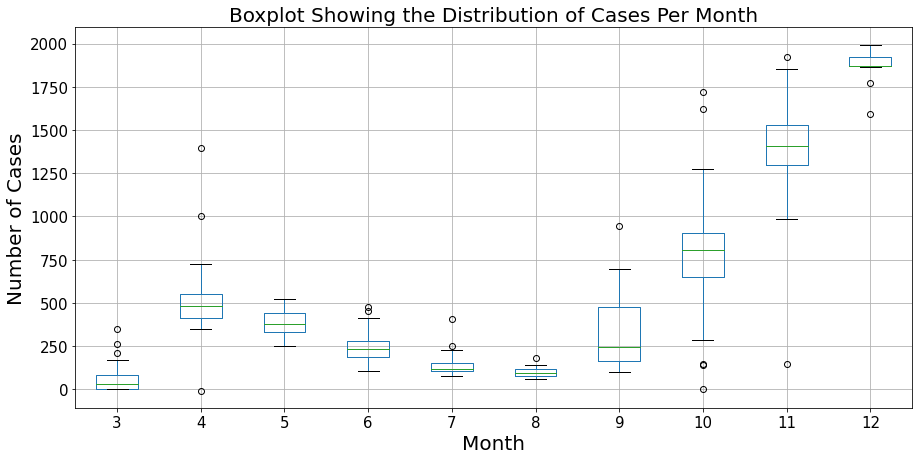

In [15]:
#A boxplot showing the monthly distribution of cases is shown in the figure below
groups = y.daily_confirmed.groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(3,13)
months.boxplot(figsize=(15,7))
plt.title('Boxplot Showing the Distribution of Cases Per Month', size=20)
plt.xlabel('Month', size=20)
plt.ylabel('Number of Cases', size=20)
plt.xticks(size=15)
plt.yticks(size=15)

From this plot, the distribution of the monthly number of coronavirus cases can be easily seen. For majority of the months, there were a few outlier cases some of them below and others above the majority of cases for the month.    
In addition, the boxplot shows a downward and upward trend in the timeseries data.   
Also, the months of April, October and November have very strong outlier case counts compared to other months.This information would be considered during the modeling process for this timeseries.

The Month of August saw the lowest distribution of daily cases while December has the highest distribution of cases for the timeseriees   
Also, the overall distribution of the confirmed cases seems to have a trend indicating that the timeseries is nonstationary. 

Text(0.5, 1.0, 'Distibution of the cumulative Numer of covid 19 cases')

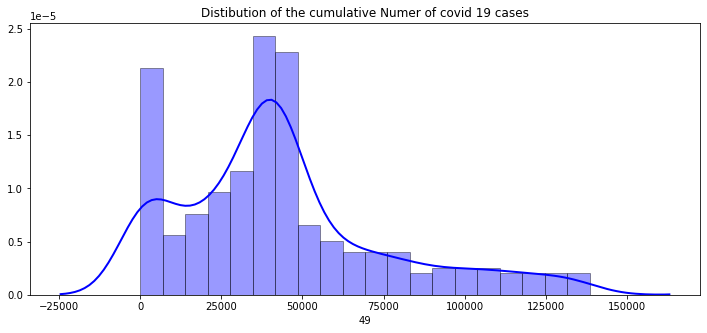

In [16]:
# frequency distriution of the timeseries
plt.figure(figsize=(12,5))
sns.distplot(y[49], hist=True, kde=True,
             bins=20,              
             color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('Distibution of the cumulative Numer of covid 19 cases')

Since some linear time series forecasting methods assume that the observations in the timeseries is normally distributed. A plot for the frequency distibution of this timeseries was made and is shown in the figure above. From this plot it can be seen that the timeseries is not normally distributed.  So, in order to model this timeseries, some transformation methods would be performed on the timeseries dataset. 

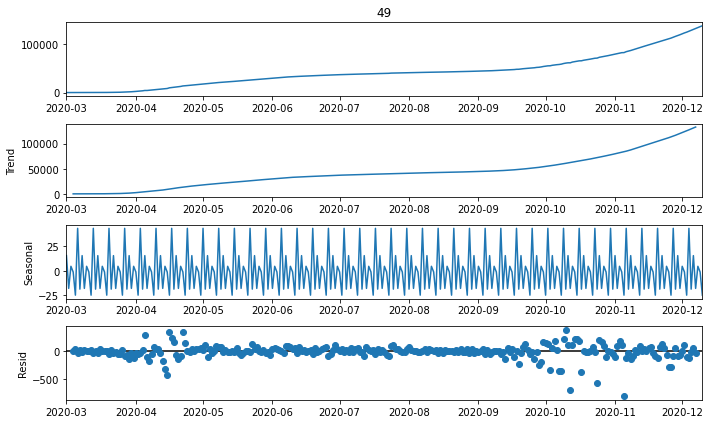

In [17]:
# to further explore the components of the timeseries and understand the time series data for easy modelling the series would be decomposed 
# into its components using the seasonal decompose package from statsmodel
result = seasonal_decompose(y[49])
plt.rc("figure", figsize=(10,6))
result.plot()
plt.show()

Since a timeseries is composed of level; trend; seasonality; and noise, the cumulative number of cases for this timeseries was decomposed into its component parts to understand the data better and choose the right forecasting approach for this timeseries. This decomposition is shown in the figure above. The above decomposition suggest that the timeseries has a trend, seasonality and noise component. The noise component in this time seris is suggested to have a greater value sometime between the months of April and May; and October to November. 

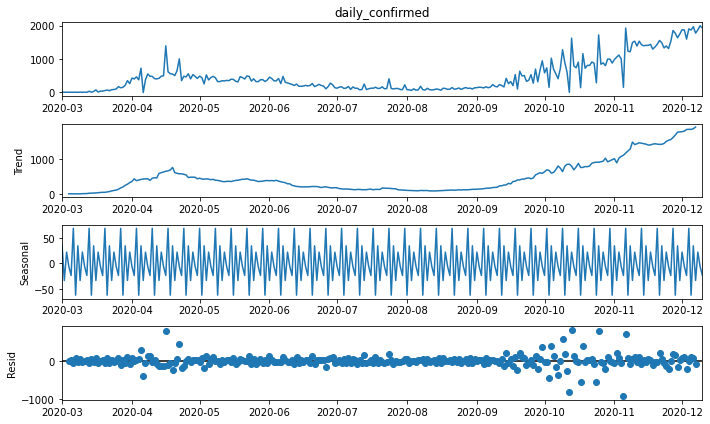

In [18]:
# seasonal decomposition of the number of daily cases
result = seasonal_decompose(y['daily_confirmed'])
plt.rc("figure", figsize=(10,6))
result.plot()
plt.show()

Further Exploratuon of the number of daily cases for this timeseries data of covid 19 is shown in the figure above. The figure also suggests a trend, seasonality and noise component (having greater value between April and May; and between October and November) for this timeseries. The above information obtained from this timeseries would be used in modelling.

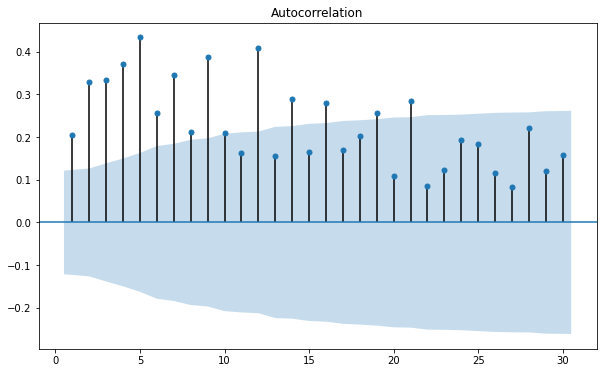

In [19]:
# An acf plot of the rolling mean of the timeseries to determine the period of the seasonality in the time series.
rolling = y.daily_confirmed-y.daily_confirmed.rolling(25).mean()
rolling = rolling.dropna()
plot_acf(rolling,lags=30,zero=False)
plt.show()

From this plot, the first peak occurs at a lag of 5, this suggest that the period of the seasonality of the timeseries is 5; although the peaks after the lag of 5 does not show a consistency in this period,this informaion of the period being 5 would be used in the modeling of the time series.

### MODEL SELECTION AND FITTING TO DATA

###### AN ARIMA MODEL WOULD BE USED FOR THIS ANALYSIS

The Box-Jenkins Apprach to time series analysis: System Idenification, estimation of parameters, Evaluation of parameters and Forecasting using the chosen model would be followed for this analysis.    
##### System Identification
 An ADF test to check for stationarity in the timeseries is performed here, since we know from EDA that the time series contains trend and seasonality. 
 The ADF test is more sensitive to nonstationarity resulting from trend in the timeseries.

In [20]:
results = adfuller(y[49])
print('Test statistics: ', results[0], '\n')
print('p-value: ', results[1])

Test statistics:  1.04156281229611 

p-value:  0.9946856903774699


<Figure size 720x360 with 0 Axes>

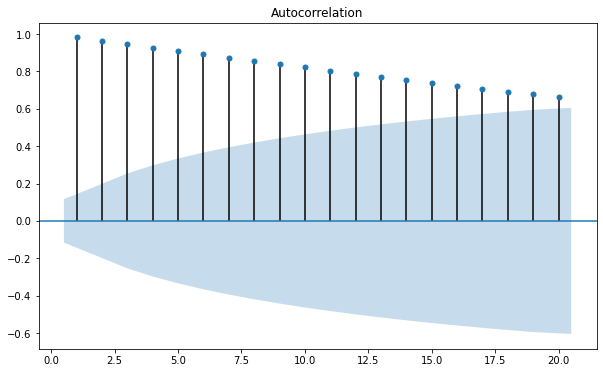

In [21]:
# test confirms the data is non stationary, so plot the ACF to check again
plt.figure(figsize=(10,5))
plot_acf(y[49],lags=20,zero=False)
plt.show()
#the acf of timeseries decays very slowly, timeseries is non stationary

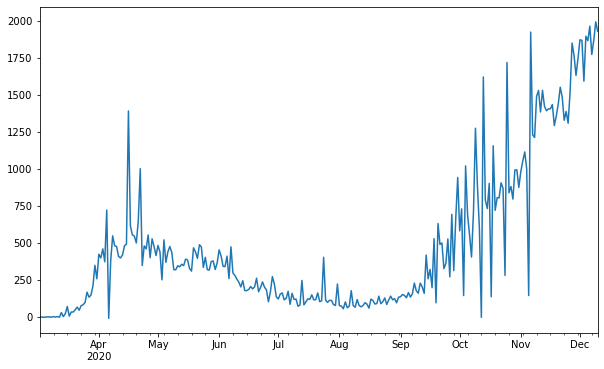

In [22]:
# to transform the data to a stationary one, the timeseries would be differenced
y_differenced=y[49].diff().dropna()
y_differenced.plot()

The differneced data seems not stationary, to confirm this an ADF test would be done again and the ACF would be inspected again

In [24]:
#ADF confirms the differenced data is also non stationary
results2 = adfuller(y_differenced)
print('Test statistics: ', results2[0], '\n')
print('p-value: ', results2[1])

Test statistics:  1.848351715167787 

p-value:  0.9984402441361838


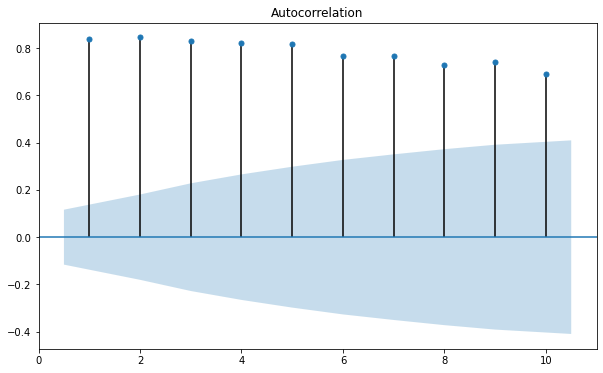

In [25]:
# acf decays slowly, differenced data is non stationary, so difference again
plot_acf(y_differenced,lags=10,zero=False)
plt.show()

In [26]:
y_stationary=y_differenced.diff().dropna()

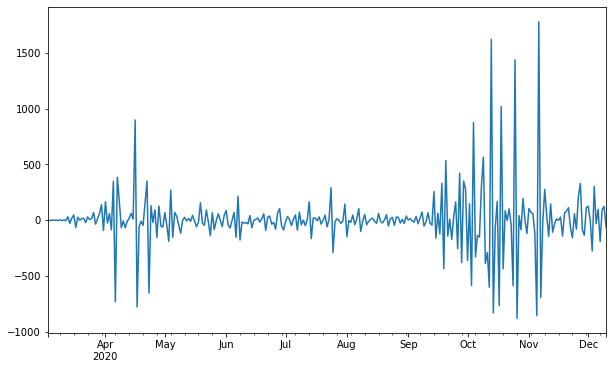

In [27]:
y_stationary.plot()

Looks stationary although it seems to have some noise between april and may; and october and november as indicated from the seasonal decomposition and boxplot of the timeseries dataset

In [28]:
results3 = adfuller(y_stationary)
print('Test statistics: ', results3[0], '\n')
print('p-value: ', results3[1])

Test statistics:  -5.698429619520508 

p-value:  7.776264954444977e-07


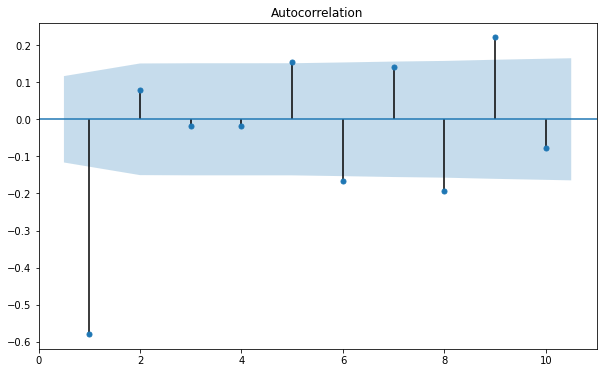

In [29]:
# plot ACF
plot_acf(y_stationary,lags=10,zero=False)
plt.show()


ACF decays quickly. so, a plot of the acf and pacf for this dataset would be done to determine the p and q order of the ARIMA model.

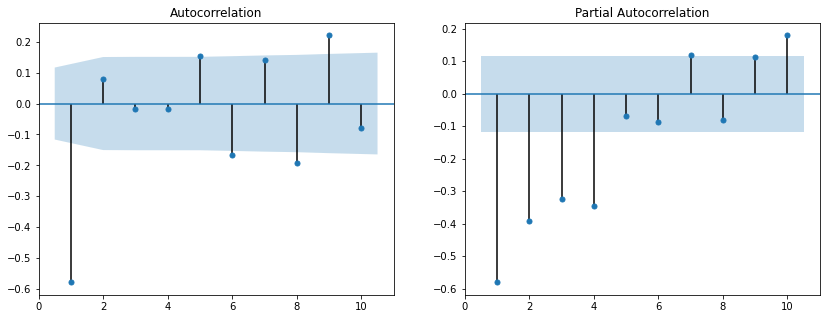

In [30]:
#plot acf and pacf to determine model order
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
plot_acf(y_stationary,lags=10,zero=False,ax=ax1)
plot_pacf(y_stationary, lags=10,zero=False, ax=ax2)
plt.show()

The order of the model can't be decided from the acf and pacf of this timeseries, so, grid search for parameters using AIC and BIC error tests would be used.

In [90]:
# Collecting a section of the dataset that contains significant trends in the dataset, to use for fitting the model
y_base=y[49].iloc[:220]
y_worst=y[49].iloc[:60]
y_best = y[49].iloc[:185]

The pmd autoarima package fom statsmodels is used here to determine the order of the models that would be used for this time series modelling and forecasting.    
pmd autoarima using the hyperparameter limits and the information provided would search through the combination of hyperparameters to find the set of hyperparamters that gives the lowest aic (error) for the timeseries dataset. Here a period of 5 is specified as well as upper and lower limits of the orders of the ARIMA model to search for.

In [99]:
res_best = pm.auto_arima(y_best,start_p=1,
                    d=None,start_q=1,max_p=10,max_d=10,max_q=10,start_P=1,seasonal=True,
                    D=None,start_Q=1,max_P=5,max_D=4,max_Q=12, max_order=5,m=5)
print(res_best.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  185
Model:             SARIMAX(2, 2, 2)x(2, 0, [], 5)   Log Likelihood               -1117.069
Date:                            Fri, 29 Jan 2021   AIC                           2248.138
Time:                                    20:08:25   BIC                           2270.604
Sample:                                         0   HQIC                          2257.245
                                            - 185                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6957      0.104      6.705      0.000       0.492       0.899
ar.L2         -0.3539      0.106   

From this search, the combination chosen is a combination consisting of ARIMA order=(2,2,2) and a seasonal component with the seasonal order=(2,0,0,5)

In [100]:
res_base = pm.auto_arima(y_base,start_p=1,
                    d=None,start_q=1,max_p=10,max_d=10,max_q=10,start_P=1,seasonal=True,
                    D=None,start_Q=1,max_P=5,max_D=4,max_Q=12, max_order=5,m=5)
print(res_base.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  220
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1367.955
Date:                Fri, 29 Jan 2021   AIC                           2749.910
Time:                        20:10:59   BIC                           2773.634
Sample:                             0   HQIC                          2759.492
                                - 220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8107      0.965      0.840      0.401      -1.080       2.701
ar.L1          1.9141      0.101     19.021      0.000       1.717       2.111
ar.L2         -0.9168      0.102     -9.014      0.0

From this search, the combination chosen is a combination consisting of ARIMA order=(2,1,3) 

In [101]:
res_worst = pm.auto_arima(y_worst,start_p=1,
                    d=None,start_q=1,max_p=10,max_d=10,max_q=10,start_P=1,seasonal=True,
                    D=None,start_Q=1,max_P=5,max_D=4,max_Q=12, max_order=5,m=5)
print(res_worst.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -382.146
Date:                Fri, 29 Jan 2021   AIC                            770.292
Time:                        20:11:05   BIC                            776.473
Sample:                             0   HQIC                           772.700
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.2771      8.449      1.216      0.224      -6.282      26.836
ma.L1         -0.8034      0.114     -7.056      0.000      -1.027      -0.580
sigma2      3.042e+04   3525.472      8.629      0.0

From this search, the combination chosen is a combination consisting of ARIMA order=(0,2,1)

###### Evaluation of Identified and Estimated Parameters --- explanation in the evaluation section after fitting the model to the selected parameters

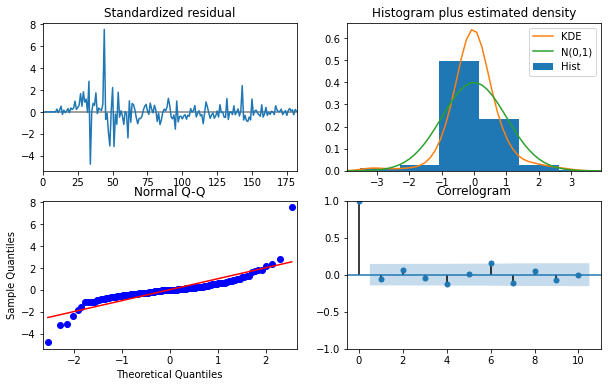

In [102]:
res_best.plot_diagnostics()
plt.show()

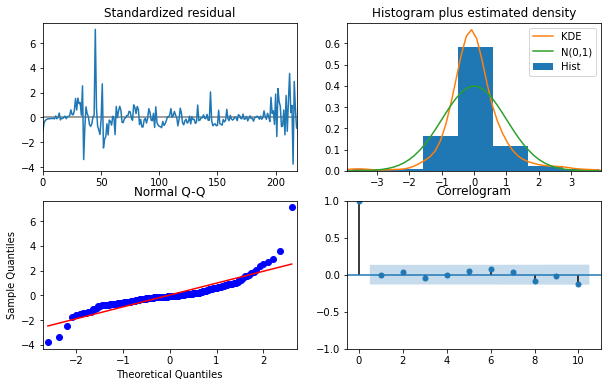

In [103]:
res_base.plot_diagnostics()
plt.show()

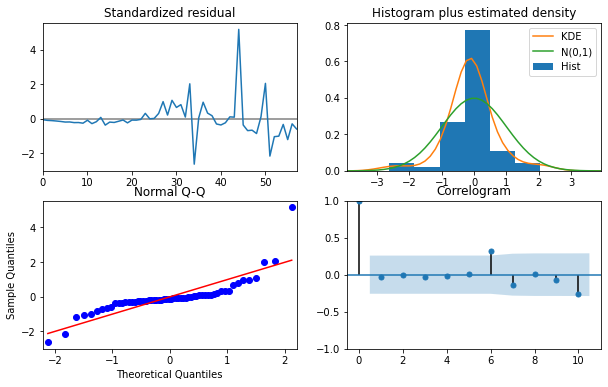

In [104]:
res_worst.plot_diagnostics()
plt.show()

##### Parameter Estimation

In [105]:
# fitting the ARIMA model for the best case scenario forecast with the chosen orders.
model_chosen_best=SARIMAX(y_best,order=(2, 2, 2), seasonal_order=(2, 0, 0, 5))
result_best=model_chosen_best.fit()
# Also checking the result summary. Same as results from identification using pmd auto-arima
result_best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 49   No. Observations:                  185
Model:             SARIMAX(2, 2, 2)x(2, 0, [], 5)   Log Likelihood               -1117.069
Date:                            Fri, 29 Jan 2021   AIC                           2248.138
Time:                                    21:25:44   BIC                           2270.604
Sample:                                03-01-2020   HQIC                          2257.245
                                     - 09-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6957      0.104      6.705      0.000       0.492       0.899
ar.L2         -0.3539      0.106     -3.336      0.001      -0.562      -0.146
ma.L1         -1.4667      0.099    -14.877      0.000      -1.660      -1.273
ma.L2          0.7866      0.074     10.580      0.000       0.641       0.932
ar.S.L5       -0.2030      0.128     -1.592      0.111      -0.453       0.047
ar.S.L10      -0.1816      0.054     -3.348      0.001      -0.288      -0.075
sigma2      1.162e+04    694.987     16.725      0.000    1.03e+04     1.3e+04
===================================================================================
Ljung-Box (Q):                       35.22   Jarque-Bera (JB):              3100.65
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             1.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
# fitting the ARIMA model for the base case scenario forecast with the chosen orders.
model_chosen_base=SARIMAX(y_base,order=(2, 1, 3))
result_base=model_chosen_base.fit()
# Also checking the result summary. Same as results from identification using pmd auto-arima
result_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     49   No. Observations:                  220
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1373.278
Date:                Fri, 29 Jan 2021   AIC                           2758.555
Time:                        21:25:46   BIC                           2778.889
Sample:                    03-01-2020   HQIC                          2766.768
                         - 10-06-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0714      0.480      0.149      0.882      -0.869       1.012
ar.L2          0.9212      0.478      1.928      0.054      -0.015       1.858
ma.L1          0.0070      0.479      0.015      0.988      -0.931       0.945
ma.L2         -0.6511      0.428     -1.520      0.129      -1.491       0.189
ma.L3          0.1971      0.098      2.013      0.044       0.005       0.389
sigma2      1.615e+04    633.168     25.505      0.000    1.49e+04    1.74e+04
===================================================================================
Ljung-Box (Q):                       26.92   Jarque-Bera (JB):              2412.72
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             2.03
Prob(H) (two-sided):                  0.06   Kurtosis:                        18.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Using the chosen parameters from the auto arima parameter search showed significant values in lag 6 of the model residuals of the ARIMA model. So, other p and q orders for the model were explored until a suitable model order was found that had no significant values in the model residuals.

In [110]:
# fitting the ARIMA model for the worst case scenario forecast with the chosen orders .
model_chosen_worst=SARIMAX(y_worst,order=(2, 2, 6))
result_worst=model_chosen_worst.fit()
# Also checking the result summary. Same as results from identification using pmd auto-arima
result_worst.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     49   No. Observations:                   60
Model:               SARIMAX(2, 2, 6)   Log Likelihood                -377.263
Date:                Fri, 29 Jan 2021   AIC                            772.527
Time:                        21:28:19   BIC                            791.071
Sample:                    03-01-2020   HQIC                           779.750
                         - 04-29-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1552      0.244     -4.729      0.000      -1.634      -0.676
ar.L2         -0.7280      0.204     -3.569      0.000      -1.128      -0.328
ma.L1          0.5521      0.570      0.969      0.333      -0.565       1.669
ma.L2         -0.1065      0.198     -0.539      0.590      -0.494       0.281
ma.L3         -0.5936      0.484     -1.227      0.220      -1.542       0.354
ma.L4          0.1136      0.270      0.420      0.674      -0.416       0.643
ma.L5          0.0366      0.251      0.146      0.884      -0.455       0.529
ma.L6          0.3306      0.323      1.024      0.306      -0.302       0.963
sigma2      2.411e+04   1.78e+04      1.355      0.175   -1.08e+04     5.9e+04
===================================================================================
Ljung-Box (Q):                       15.60   Jarque-Bera (JB):               161.71
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):             139.61   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Evaluation

From the model summary results of the three models, the Ljung-Box test shows a p-value greater than 0.05, indicating that the residuals are uncorrelated. However, the Jarque-Bera (JB) test shows that the residuals are not normally distributed, with skewness ranging from 0.89 to 2.03 and kurtosis ranging from 10.98 to 22.90. For further analysis, the diagnostics plot for this model is shown below.  
From these plots, The noise component that was observed from the seasonal decomposition of the data is observed on the plot of the standardized residuals for these model. As confirmed by the JB test on these residuals, these residuals are not normally distributed which could be due to the spikes seen in the resids plot in April from seasonal decomposition of the timeseries. However, the mean of the timeseries models seems centered around zero from the plots of the Histogram plus estimated density, although these plot also show that the data is not normally distributed as it is skewed. Also, the Normal Q-Q plot shows the data is very close to the normality line except for the cases of some outliers. Since the correlogram of all models show all the residuals within the confidence bounds, these hyperparameters would be chosen for this modeling.

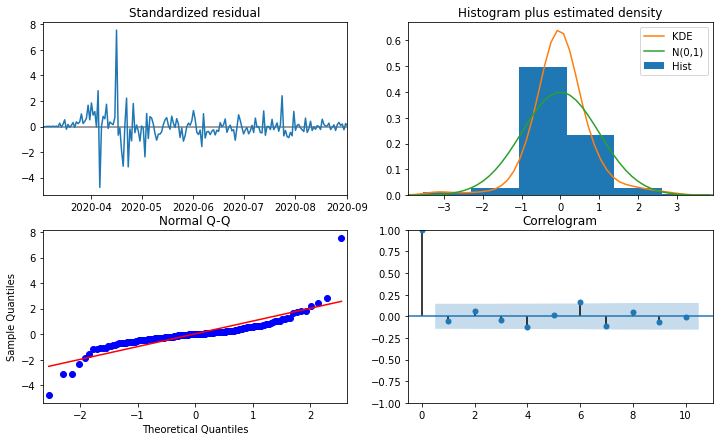

In [111]:
# checking the diagnostics plot. Same as the plot from system identification
result_best.plot_diagnostics(figsize=(12,7))
plt.show()

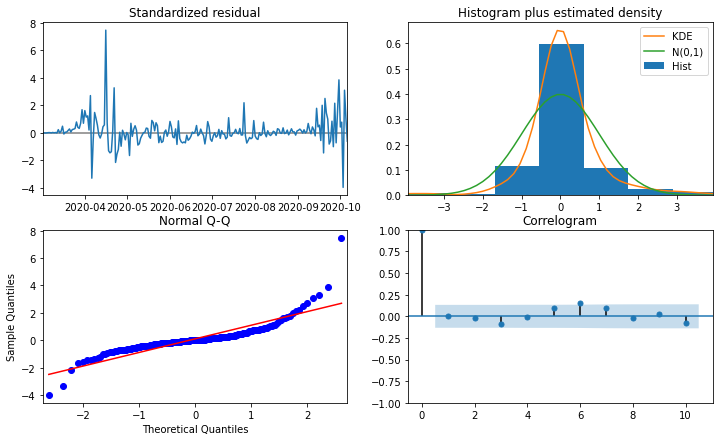

In [112]:
# checking the diagnostics plot. Same as the plot from system identification
result_base.plot_diagnostics(figsize=(12,7))
plt.show()

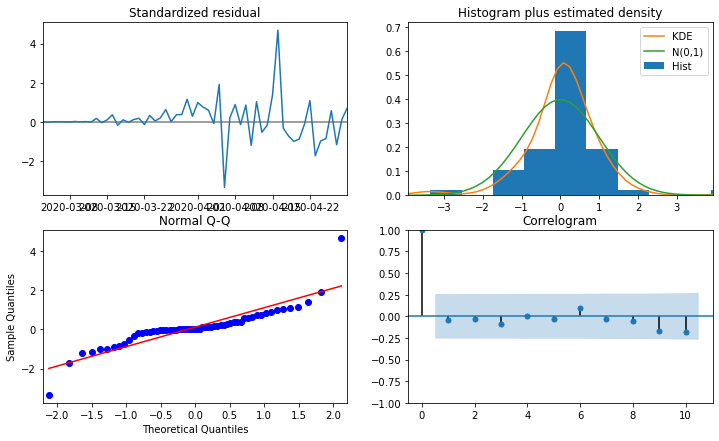

In [113]:
# checking the diagnostics plot. Same as the plot from system identification
result_worst.plot_diagnostics(figsize=(12,7))
plt.show()

###### Forecasting

The model used for the best case scenario forecast was trained on data from the beginning of the pandemic up unto the period when there was significnt reduction in the daily case numbers. So, the best case scenario assumes that the daily case number continues with this daily case reduction trend.     
The model used for the worst case scenario forecast was trained on data from the first wave of the pandemic when case numbers continually increased with no foreseeale decline in daily case numbers. Hence, the model assumes that the daily case numbers continually increased through out the time of the forecast.      
The model used for the base case scenario forecast was trained on data from the beginning of the pandemic up until the period the daily case numbers began increasing after decreasing. Hence, the model's forecast of the base case scenario is based on this trend.

The  Base-case, Best-case and worst-case scenarios forecasts are shown in the figure below along with the observed case.    

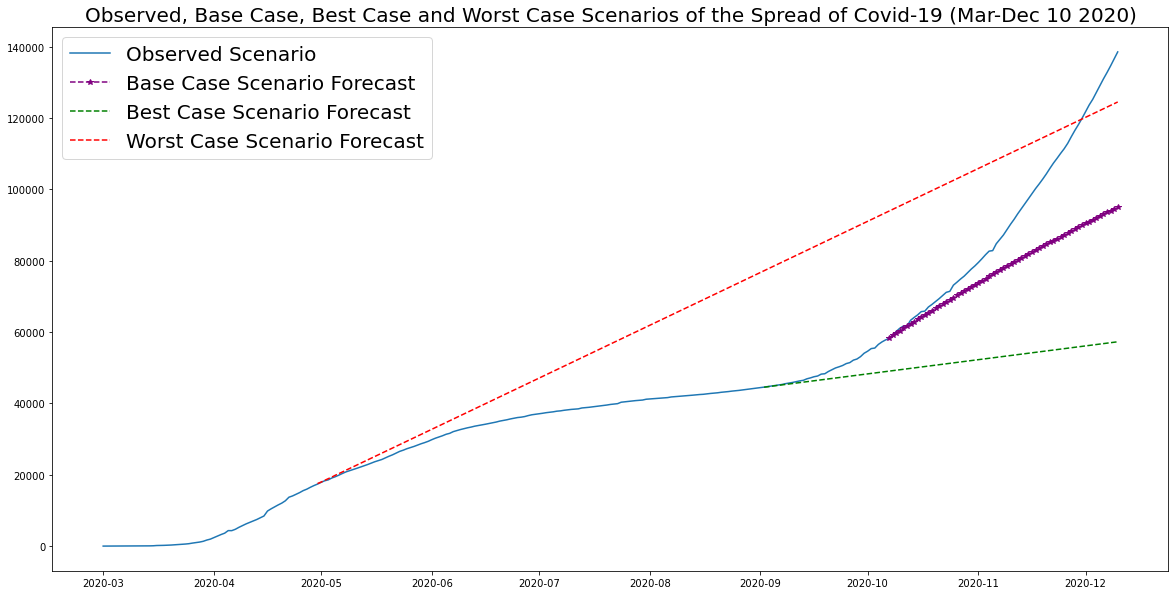

In [166]:
future_best = result_best.get_forecast(steps=100)
f_best = future_best.predicted_mean
future_base = result_base.get_forecast(steps=65)
f_base = future_base.predicted_mean
future_worst = result_worst.get_forecast(steps=225)
f_worst = future_worst.predicted_mean
plt.figure(figsize=(20,10))
plt.plot(y[49],label='Observed Scenario')
plt.plot(f_base.index, f_base, label='Base Case Scenario Forecast',ls="--",color="purple", marker = "*")
plt.plot(f_best.index,f_best,label='Best Case Scenario Forecast',color='green',ls='--')
plt.plot(f_worst.index, f_worst, label='Worst Case Scenario Forecast',color='red', ls ='--')
plt.title('Observed, Base Case, Best Case and Worst Case Scenarios of the Spread of Covid-19 (Mar-Dec 10 2020)', size=20)
plt.legend(fontsize=20)

In [137]:
print('Best Case Scenario Forecast: ' , f_best[-1:])

Best Case Scenario Forecast:  2020-12-10    57282.541882
Freq: D, dtype: float64


In [138]:
print('Worst Case Sceario Forecast: ' , f_worst[-1:])

Worst Case Sceario Forecast:  2020-12-10    124495.82265
Freq: D, dtype: float64


In [139]:
print('Base Case Scenario Forecast:' , f_base[-1:])

Base Case Scenario Forecast: 2020-12-10    95066.061335
Freq: D, dtype: float64


In [146]:
print('Actual Case Count: ', y[49][-1:])

Actual Case Count:  2020-12-10    138529.0
Name: 49, dtype: float64


##### According to the forecast of these models, the cumulative number of cases in Ontario by the 10th of December 2020 in the best case scenario would be approximately 58,000 cases, the worse case scenario would be 125,000 cases and the base case scenario would be approximately 95,000 cases.

### Relating COVID-19 Projections to a Second Dataset

#### Effect of International Movement Restrictions

In this part of the project, the effect of international movement restrictions on the projections of the three models
would be analyzed.

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000., 140000., 160000.]),
 <a list of 10 Text major ticklabel objects>)

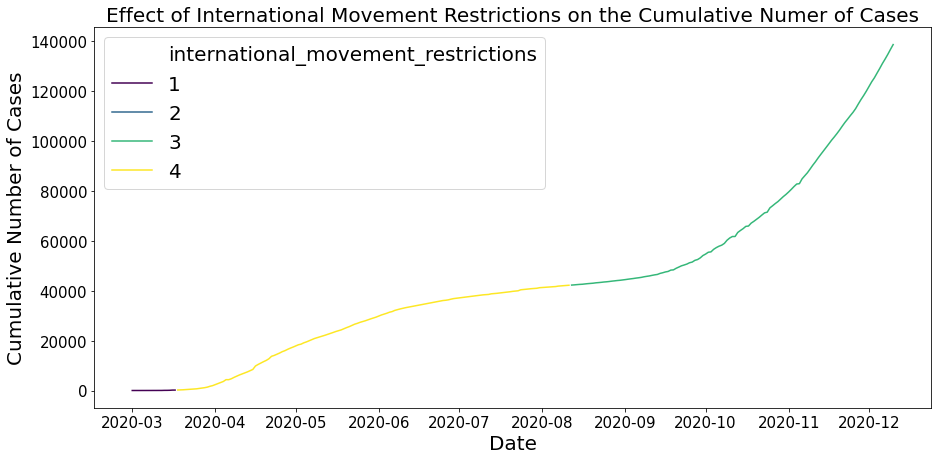

In [145]:
plt.figure(figsize=(15,7))
sns.lineplot(x=data2_onts.index, y=y[49],hue=data2_onts.international_movement_restrictions,palette='viridis')
plt.title('Effect of International Movement Restrictions on the Cumulative Numer of Cases', size=20)
plt.ylabel('Cumulative Number of Cases')
plt.legend(fontsize=20)
plt.xlabel('Date', size=20)
plt.ylabel('Cumulative Number of Cases', size=20)
plt.xticks(size=15)
plt.yticks(size=15)

From the above plot showing the cumulative number of cases and the various levels of international movement restrictions, it can be seen that the level of international movement restriction has an effect on the rise in the cumulative number of covid-19 cases in Ontario.

The restriction levels are explained below:    
1: Screening -   
2: Quarantine arrivals from high-risk regions -   
3: Ban on high-risk regions -   
4: Total border closure

From this plot, it is seen that the part of the curve showing total border closure has a flat curve or a smaller slope when compared to the part of the curve where a Ban on high-risk regions was implemented. Just a few weeks after the reopening of the border the curve steeps upwards and continues in that direction for the duration of this timeseries.
###### Relating this Factor to the projections of the model in Part 3
The best case scenario forecast was done by an ARIMA trained on data up until the end of August,just before the level of international movement restriction moved from level 4 to 3. So, it can be said that the projection made by this model for the best case scenario was based mainly on the level 4 international movement restrictions being maintained. However, the observed/actual number of cases for this time period is higher than this scenario projection of this model. This Indicates that the change in this factor had an effect on the increasing cumulative number of cases in Ontario.

The base case scenario was forecasted by an ARIMA model trained on data up until the end of october. From the plot showing the effect of international movement restrictions on the cumulative number of cases in Ontario, it can be seen that the flattened curve began rising somewhere around the end of september and the beginning of october right after the restriction on international movement changed from level 4 to level 3. So, this model captured this gradual rise in the number of cases after this change and made forecasts based on this initial rise, leading to a higher cumulative case number forecast than the model trained on cumulative case number where the level 4 international movement restriction was dorminant.


The worst case scenario was forecasted by an ARIMA model trained on data from the first wave (the first 60 days of the cumulative case numbers in Ontario). This data showed a continuous increase in the cumulative number of cases at an increasing pace with a steep slope right before the effects of the various restrictions placed to restrict the spread of the virus began kicking in. Assuming case number continually increased at this pace, the cumulative number of cases is shown to be about 14000 cases lower than the cumulative observed case numbers by the 10th of December 2020. Although this forecast shows a steady continuous rise in the cumulative case numbers when the observed cumulative case numbers where lower, the observed cumulative case numbers later showed an exponential rise that caused the observed cumulative case numbers to exceed the cumulative case numbers from the worst case scenario forecast. From the plot of the effect of international travel restriction on the cumulative case numbers, this exponential rise is shown to begin after the international travel restriction moved from level 4 to level 3.

This analysis shows that this factor has an effect on the increasing cumulative case numbers in Ontario

For a clearer analysis of the effect of this factor on the number of cases, a plot of the daily confirmed cases would also be used

(array([-250.,    0.,  250.,  500.,  750., 1000., 1250., 1500., 1750.,
        2000., 2250.]),
 <a list of 11 Text major ticklabel objects>)

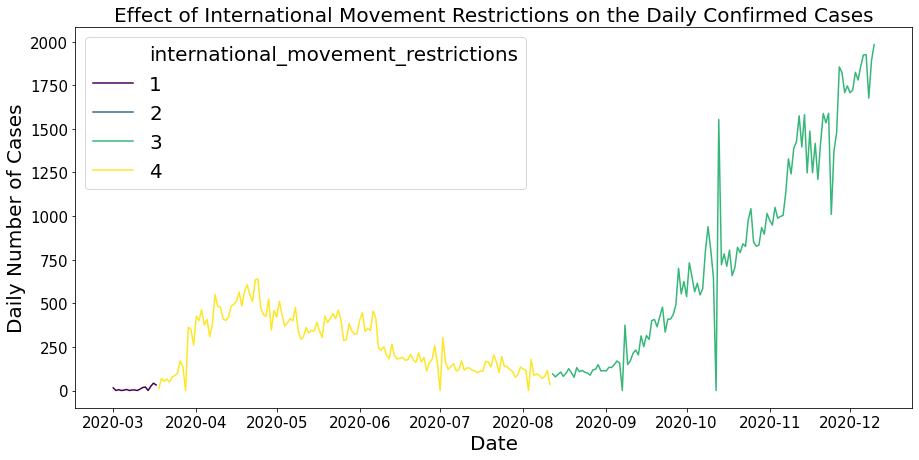

In [45]:
plt.figure(figsize=(15,7))
sns.lineplot(x=data2_onts.index, y=data2_onts.daily_confirmed,hue=data2_onts.international_movement_restrictions,palette='viridis')
plt.title('Effect of International Movement Restrictions on the Daily Confirmed Cases', size = 20)
plt.legend(fontsize=20)
plt.xlabel('Date', size=20)
plt.ylabel('Daily Number of Cases', size=20)
plt.xticks(size=15)
plt.yticks(size=15)

From this plot, it is clear that the daily number of case counts showed significant increase approximatey 2 weeks after international travel restrictions moved from level 4 to level 3. This plot shows that this change has an effect on the increase in the daily and cumulative case numbers. The daily projected case forecast of three models are shown below.

Text(0.5, 0, 'Date')

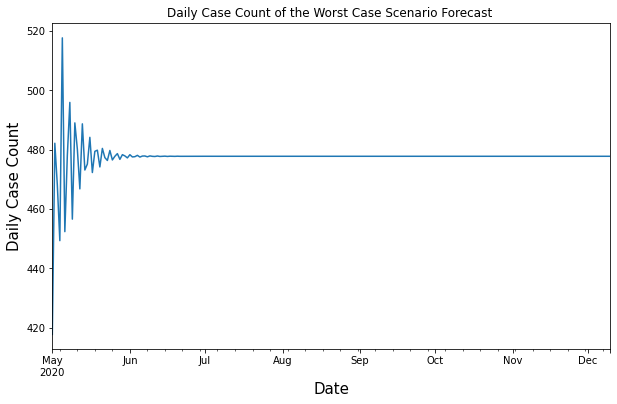

In [160]:
future_worst.predicted_mean.diff().dropna().plot()
plt.title("Daily Case Count of the Worst Case Scenario Forecast ")
plt.ylabel("Daily Case Count", fontsize=15)
plt.xlabel("Date", fontsize=15)

Text(0.5, 0, 'Date')

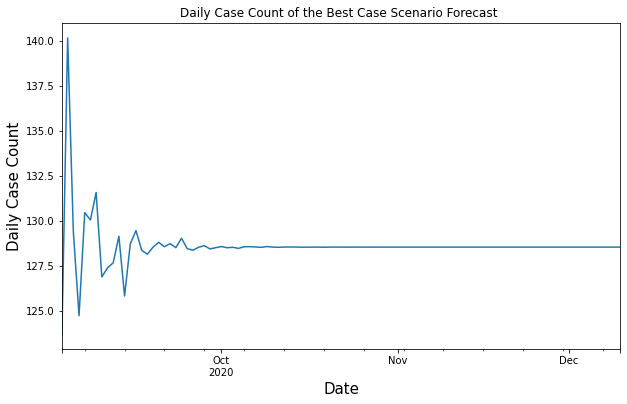

In [158]:
future_best.predicted_mean.diff().dropna().plot()
plt.title("Daily Case Count of the Best Case Scenario Forecast ")
plt.ylabel("Daily Case Count", fontsize=15)
plt.xlabel("Date", fontsize=15)

Text(0.5, 0, 'Date')

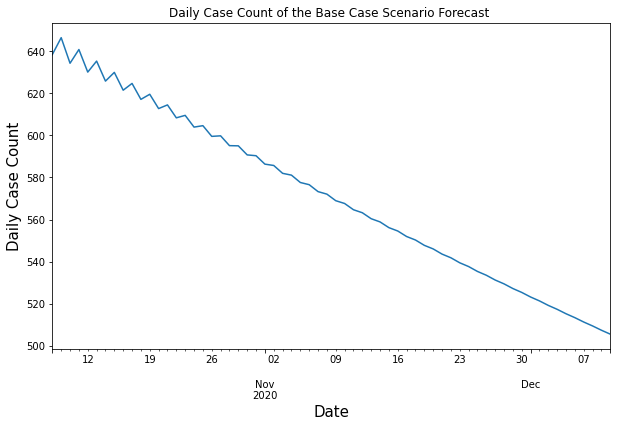

In [159]:
future_base.predicted_mean.diff().dropna().plot()
plt.title("Daily Case Count of the Base Case Scenario Forecast ")
plt.ylabel("Daily Case Count", fontsize=15)
plt.xlabel("Date", fontsize=15)

The above illustation shows that the number of projected cases for all case scenarios were lower than the observed case; and that a factor change can be attributed to this increase in the observed case number. It is important to Note that this is just one factor and several factors in combination with this factor can be attributed with this change.

#### Analysing other Factors in the Second Dataset to Draw Insights from the Dataset

Text(0.5, 1.0, ' The Goverment Stringency Index During Covid-19 Outbreak from March 2020 to December 10 2020')

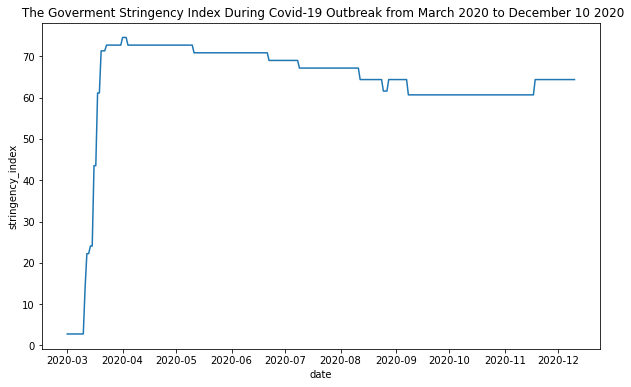

In [47]:
sns.lineplot(data2_onts.index, data2_onts.stringency_index)
plt.title(' The Goverment Stringency Index During Covid-19 Outbreak from March 2020 to December 10 2020')

The Goverment Stringency Index During Covid-19 Outbreak from March 2020 to December 10 2020    
A higher value signifies greater stringent measures

The figure above shows that the lowest stringency index between Septemer to the beginning of December 2020 and this corresponds to the higher number of daily cases during this period. In addition, although the stringency index, increased to the level it was before dropping in September, the plot of the observed cases still shows an increase in the number of daily cases. Some other factors considered are shown below

##### STAY HOME RESTRICTIONS

Text(0, 0.5, 'Cumulative Case number')

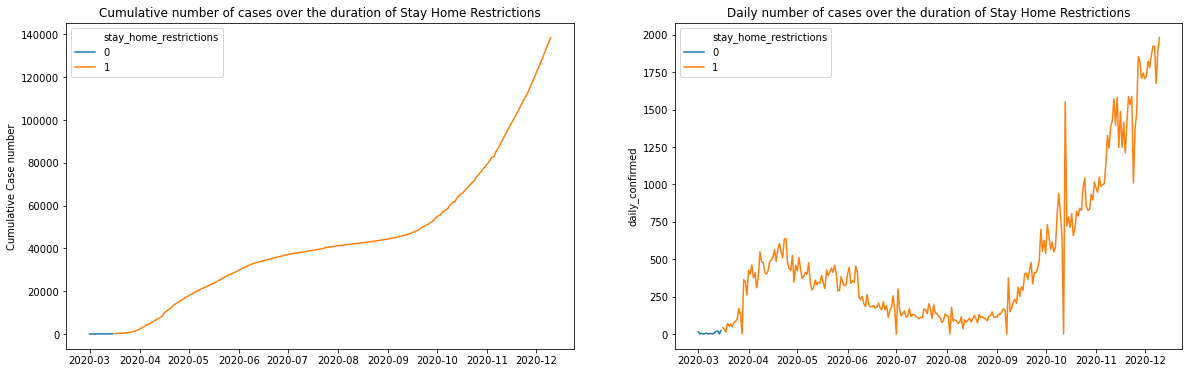

In [48]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))
sns.lineplot(y.index,y[49], hue=data2_onts.stay_home_restrictions, ax=ax1)
sns.lineplot(y.index, data2_onts.daily_confirmed, hue = data2_onts.stay_home_restrictions, ax=ax2)
ax1.set_title('Cumulative number of cases over the duration of Stay Home Restrictions')
ax2.set_title('Daily number of cases over the duration of Stay Home Restrictions')
ax1.set_ylabel('Cumulative Case number')

0 - No measures  
1 - recommend not leaving house   

This figure shows a decrease and an increase in case numbers irrespective of the stay home recommndation

##### TESTING POLICY

Text(0, 0.5, 'Cumulative Case number')

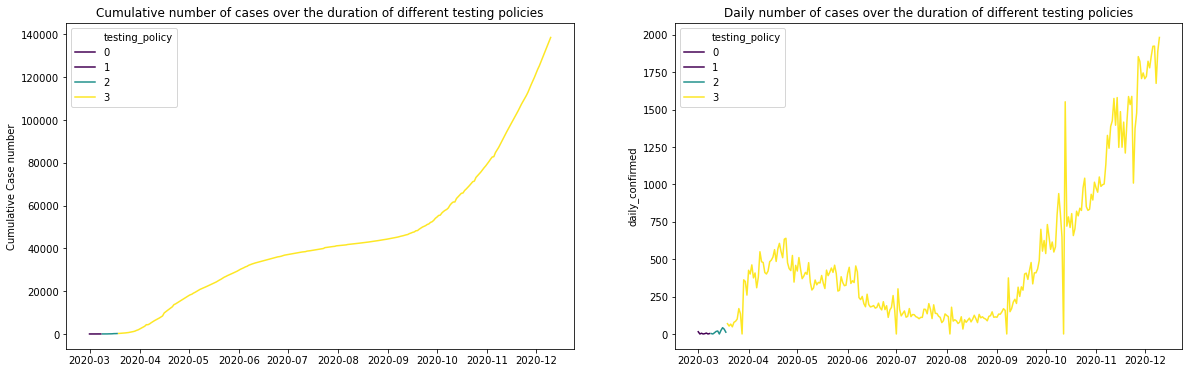

In [49]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))
sns.lineplot(y.index,y[49], hue=data2_onts.testing_policy, ax=ax1, palette='viridis')
sns.lineplot(y.index, data2_onts.daily_confirmed, hue = data2_onts.testing_policy, ax=ax2, palette='viridis')
ax1.set_title('Cumulative number of cases over the duration of different testing policies')
ax2.set_title('Daily number of cases over the duration of different testing policies')
ax1.set_ylabel('Cumulative Case number')

0 – No testing policy   
1 – Only those who both (a) have
symptoms AND (b) meet specific criteria
(eg key workers, admitted to hospital,
came into contact with a known case,
returned from overseas)    
2 – testing of anyone showing COVID-19
symptoms     
3 – open public testing (eg “drive through”
testing available to asymptomatic people)

This Figure shows a decrease and an Increase in daily case numbers irrespective of the testing policy implemented

#### WORKPLACE CLOSING

Text(0, 0.5, 'Cumulative Case number')

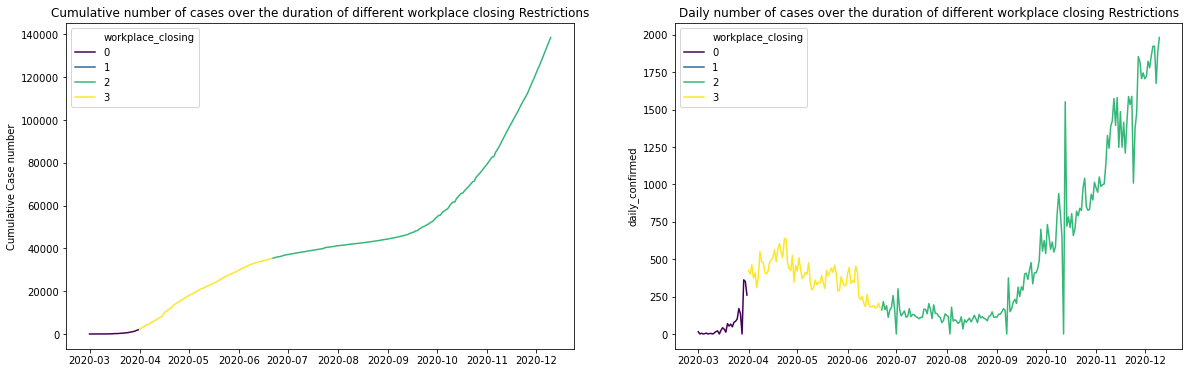

In [50]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))
sns.lineplot(y.index,y[49], hue=data2_onts.workplace_closing, ax=ax1, palette='viridis')
sns.lineplot(y.index, data2_onts.daily_confirmed, hue = data2_onts.workplace_closing, ax=ax2,palette='viridis')
ax1.set_title('Cumulative number of cases over the duration of different workplace closing Restrictions')
ax2.set_title('Daily number of cases over the duration of different workplace closing Restrictions')
ax1.set_ylabel('Cumulative Case number')

0 - No measures  
1 - recommend closing (or work from
home)  
2 - require closing (or work from
home) for some sectors or categories
of workers   
3 - require closing (or work from home)
all-but-essential workplaces (eg grocery
stores, doctors)

This figure shows that when the workplace closing restrictions moved from level 3 to level 2, it took about approximatedly three months for an increase in the daily confirmed cases of covid 19. Hence it may be inferred that this factor may have a delayed effect on the rise in covid 19 cases ie its effect on the number of daily covid 19 cases may not be immediate.

### Deriving insights about policy and guidance to tackle the outbreak based on model findings

From the Analysis performed in the 3rd and 4th Part of this Project, and from the analysis of other factors, it can be inferred that a change in the international movement restrictions had the most significant effect on the daily increase in the number of covid-19 cases in Ontario.

Although there may be other factors that work in conjuction with this facor leading to an increase in the number of covid-19 cases, the factor analyzed in this project would be used to propose measures to fight against covid-19.  
From Part 3 We See that the model Projected a cumulative Worst Case Count of approximately 125,000 for Ontario by the 10th of December 2020. This model made this projections based on the fitted dataset that had some policies that were in place which were later changed sometime later in the observed dataset.  
The Part 4 of this project revealed that of all the policies examined, the change in the International Travel Restrictions had the most significant effect on the daily rise in cases based on the data provided.  
From the observed/ provided timeseries dataset,the cumulative number of cases in Ontario on the 10th of December 2020 was approximately 139,000 Cases. Approximately 14,000 cases more than the projected number of cases.  
Based on these analysis, scientists, doctors, nurses, healthcare professionals, industry and governments can use the insights to make international travel decisions such as restricting international travel as much as is possible, employing personnels resident within the country or creating a framework where international employees can perform most and if possible all Job duties from their home countries, in order to assist in the fight against the covid-19 pandemic. In addition, the goverment of Ontario can look into the current international travel restrictions to find any significant cause of the increase in the number of daily covid 19 cases. Also, stronger international travel policies and guidelines may be examined to create a framework that would help to further restricts the spread of this virus. 